In [1]:
import numpy as np
import math
import numpy.ma as ma
from evtk.hl import imageToVTK
import matplotlib.pyplot as plt
import time

In [2]:
# Read data

originaEnsemble = np.load('data/windData/windEnsemble.npy')
print(originaEnsemble.shape)
print(originaEnsemble.max())
print(originaEnsemble.min())
mean_realization = np.mean(originaEnsemble , axis=2)
print(mean_realization.shape)

# test ensemble: Only portion of ensemble for faster processing
ensemble = originaEnsemble
print(ensemble.shape)

(68, 68, 15)
-0.14613543172773022
-80.90244063067566
(68, 68)
(68, 68, 15)


In [3]:
#sample histogram with two bins
def sampleHistogram(trueData,a1,b1,c1,numMembers,threshold):

    h,w = trueData.shape
    ensemble = np.zeros((h, w, numMembers))
    for i in range(h):
        for j in range(w):
            for k in range(numMembers):
                
                s = np.random.uniform(0,1,1)
                if (s < threshold):
                    sample = np.random.uniform(a1,b1,1)
                else:
                    sample = np.random.uniform(b1,c1,1)
                
                ensemble[i,j,k] = trueData[i,j] + sample
        
    return ensemble

In [4]:
def addRandomGaussianNoise(trueData, numMembers):
    
    h,w = trueData.shape
    ensemble = np.zeros((h, w, numMembers))
    for i in range(h):
        for j in range(w):
            for k in range(numMembers):
                randomNum = np.random.normal(0,3)
                ensemble[i,j,k] = trueData[i,j] + randomNum 
        
    return ensemble

In [5]:
def addRandomUniformNoise(trueData, numMembers):
    
    h,w = trueData.shape
    ensemble = np.zeros((h, w, numMembers))
    for i in range(h):
        for j in range(w):
            for k in range(numMembers):
                randomNum = np.random.uniform(-3,3,1)
                ensemble[i,j,k] = trueData[i,j] + randomNum 
        
    return ensemble

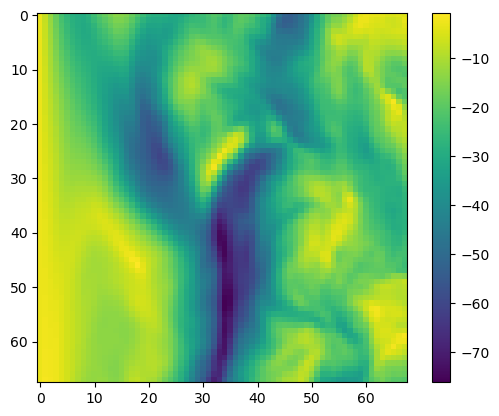

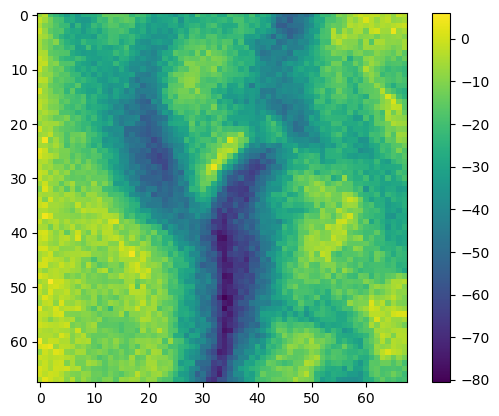

In [6]:
# Synthetic function: Mixture of four Gaussian
# define normalized 2D gaussian
#def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
#    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

#x = np.linspace(-5, 5)
#y = np.linspace(-5, 5)
#x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
#z1 = gaus2d(x, y, 2.5, 2.5, 1,1)
#z2 = gaus2d(x, y, -2.5, -2.5, 1,1)
#z3 = gaus2d(x, y, -2.5, 2.5, 1,1)
#z4 = gaus2d(x, y, 2.5, -2.5, 1,1)
#trueData = -(z1+z2+z3+z4)
#img = plt.imshow(trueData)
#plt.colorbar(img)



# Treat first ensemble member as the truth
trueData = originaEnsemble[:,:,0]
img = plt.imshow(trueData)
plt.colorbar(img)

# Add Gaussian noise samples per grid vertex to generate ensemble
ensemble = addRandomGaussianNoise(trueData, 50)
plt.figure()
img = plt.imshow(ensemble[:,:,0])
plt.colorbar(img)

# Add noise samples from histogram with two bins with 0.8 weight to first bin and 0.2 to the second
#ensemble = sampleHistogram(trueData,0,1.5,3,50,0.8)
#plt.figure()
#img = plt.imshow(ensemble[:,:,0])
#plt.colorbar(img)
#ensemble = np.zeros((68,68,1))
#ensemble[:,:,0] = trueData
#print(ensemble.shape)

In [7]:
# At each grid vertex, compute the probabillity of values being less than and greater than the isovalue
def computePositiveNegativeProbabilities(ensemble, isovalue, distributionModel, numBins):
    h, w, d = ensemble.shape
    
    # Contain minimum and maximum at each grid point
    minimumGrid = np.zeros((h,w))
    maximumGrid = np.zeros((h,w))
    # Contain average at each grid point
    meanGrid = np.zeros((h,w))
    # Most probable sign. If probability of + is greater than -, then assign +.
    mostProbableGrid = np.zeros((h,w))
    
    # Contain mean and standard deviation for Gaussian distribution
    meanGaussian = np.zeros((h,w))
    stdGaussian = np.zeros((h,w))
    
    # Compute min,max,mean,standard deviation per grid vertex
    for i in range(h):
        for j in range(w):
            minimum = math.inf
            maximum = -math.inf
            t = np.array([])
            for k in range(d):
                t = np.append(t, [ensemble[i,j,k]])
                if(ensemble[i,j,k] < minimum):
                    minimum = ensemble[i,j,k]
                if(ensemble[i,j,k] > maximum):
                    maximum = ensemble[i,j,k]    
            tMean = np.mean(t,0)
            tVar = np.var(t,0)
            tStd = math.sqrt(tVar)
            
            #Uniform
            minimumGrid[i,j] = minimum
            maximumGrid[i,j] = maximum   
            
            #Gaussian
            meanGaussian[i,j] = tMean
            stdGaussian[i,j] = tStd
    
    # Compute negative and positive probabilities for different noise models
    # Pr(value <= isovalue)
    negativeProbabilitiesGrid = np.zeros((h,w))
    # Pr(value > isovalue)
    positiveProbabilitiesGrid = np.zeros((h,w))
    toPrint = True 
    toPrint = False
    for i in range(h):
        for j in range(w):
            minimum = minimumGrid[i,j]
            maximum = maximumGrid[i,j]
            meanVal = meanGrid[i,j]
            if (isovalue <= minimum):
                positiveProbabilitiesGrid[i,j] = 1.0
                negativeProbabilitiesGrid[i,j] = 0.0
            elif (isovalue >= maximum):    
                positiveProbabilitiesGrid[i,j] = 0.0
                negativeProbabilitiesGrid[i,j] = 1.0
            else:
                if distributionModel == 'theD':
                    theD = np.sort(ensemble[i,j,:])
                    if(toPrint):
                        print(ensemble[i,j,:])
                        print(theD)
                    probIndex = 0
                    for dId in range(len(theD)):
                        if(isovalue >= theD[dId]):
                            probIndex = probIndex + 1
                        else:
                            break
                    tempNegativeProb = (probIndex+(isovalue-theD[probIndex-1])/(theD[probIndex]-theD[probIndex-1]))/(len(theD)-1)
                    if(toPrint):
                        print("probIndex: ", probIndex)
                        print("theD[probIndex-1]", theD[probIndex-1])
                        print("(isovalue-theD[probIndex-1])", (isovalue-theD[probIndex-1]))
                        print("(theD[probIndex]-theD[probIndex-1])", (theD[probIndex]-theD[probIndex-1]))
                        print("(isovalue-theD[probIndex-1])/(theD[probIndex]-theD[probIndex-1])", (isovalue-theD[probIndex-1])/(theD[probIndex]-theD[probIndex-1]))
                        print("tempNegativeProb", tempNegativeProb)
                        toPrint = False
                    negativeProbabilitiesGrid[i,j] = tempNegativeProb
                    positiveProbabilitiesGrid[i,j] = 1.0 - negativeProbabilitiesGrid[i,j] 
                elif distributionModel == 'TheQ':
                    quants = np.array([])
                    quants = np.append(quants, 0)
                    quant  = 1/(numBins)
                    for q in range(numBins-1):
                        quants = np.append(quants, quant)
                        quant = quant + 1/numBins
                    quants = np.append(quants, 1)
                    theQ = np.quantile(ensemble[i,j,:], quants)
                    probIndex = 0
                    for qId in range(len(theQ)):
                        if(isovalue >= theQ[qId]):
                            probIndex = probIndex + 1
                        else:
                            break
                    negativeProbabilitiesGrid[i,j] = quants[probIndex-1]+1/numBins*(isovalue-theQ[probIndex-1])/(theQ[probIndex]-theQ[probIndex-1])
                    positiveProbabilitiesGrid[i,j] = 1.0 - negativeProbabilitiesGrid[i,j]
                    if(toPrint):
                        print("quant", quant)
                        print("quants", quants)
                        print("theQ", theQ)
                        print("quants[probIndex-1]", quants[probIndex-1])
                        print("(isovalue-theQ[probIndex-1])", (isovalue-theQ[probIndex-1]))
                        print("(isovalue-theQ[probIndex-1])/(theQ[probIndex]-theQ[probIndex-1])", (isovalue-theQ[probIndex-1])/(theQ[probIndex]-theQ[probIndex-1]))
                        print("quants[probIndex-1]+quant*(isovalue-theQ[probIndex-1])/(theQ[probIndex]-theQ[probIndex-1])", quants[probIndex-1]+1/(numBins+1)*(isovalue-theQ[probIndex-1])/(theQ[probIndex]-theQ[probIndex-1]))
                        toPrint = False
                elif distributionModel == 'uniform':
                    positiveProbabilitiesGrid[i,j] = (maximum - isovalue)/(maximum - minimum)
                    negativeProbabilitiesGrid[i,j] = 1.0 - positiveProbabilitiesGrid[i,j]
                elif distributionModel == 'Gaussian':
                    tempMean = meanGaussian[i,j]
                    tempStd = stdGaussian[i,j]
                    negativeProbabilitiesGrid[i,j] = 0.5*(1 + math.erf((isovalue - tempMean)/(math.sqrt(2)*tempStd)))
                    positiveProbabilitiesGrid[i,j] = 1.0 - negativeProbabilitiesGrid[i,j]
                elif distributionModel == 'Histogram':
                    hist, bin_edges = np.histogram(ensemble[i,j,:], bins=numBins)
                    # Normalize histogram
                    hist = hist/np.sum(hist)
                    tempNegativeProb = 0
                    for binId in range(numBins):
                        low = bin_edges[binId]
                        high = bin_edges[binId+1]
                        if (isovalue > low):
                            if (isovalue >= high):
                                tempNegativeProb = tempNegativeProb + hist[binId]
                            else:
                                tempNegativeProb = tempNegativeProb + hist[binId]*((isovalue - low)/(high - low))
                    if(toPrint):
                        print("hist", hist)
                        print(sum(hist))
                        print(bin_edges)
                        print("tempNegativeProb", tempNegativeProb)                        
                        toPrint = False
                    negativeProbabilitiesGrid[i,j] = tempNegativeProb
                    positiveProbabilitiesGrid[i,j] = 1.0 - negativeProbabilitiesGrid[i,j]   
                
                else:
                    print('No valid model')
            
            # Compute most probable grid
            if(positiveProbabilitiesGrid[i,j] > negativeProbabilitiesGrid[i,j]):
                mostProbableGrid[i,j] = (meanVal + maximum)/2
            else:
                mostProbableGrid[i,j] = (minimum + meanVal)/2  
            
    
    return positiveProbabilitiesGrid, negativeProbabilitiesGrid, maximumGrid, minimumGrid, mostProbableGrid

In [8]:
# Takes positive sign probability and negative sign probability values per grid vertex as input (computed in previous function),
# to produce histogram of marching squares topology cases. The probability is therefore computed for each of the 16 cases.
# Followed by that, entropy and number of nonzero cases are computed for histogram of marching cubes cases
# High entropy means higher uncertainty

def computeMSTopologyCasesProbabilities(positiveProbabilitiesGrid, negativeProbabilitiesGrid):
    h, w = positiveProbabilitiesGrid.shape
    MStopologyCasesProbabilities = np.zeros((h-1,w-1,16))
    # Record number of cases per cell as well
    numCases = np.zeros((h-1,w-1))

    tempNumCases = 1
    for i in range(h-1):
        for j in range(w-1):
            
            x1Positive = positiveProbabilitiesGrid[i,j]
            x1Negative = negativeProbabilitiesGrid[i,j]
            if(x1Positive > 0) and (x1Positive < 1):
                tempNumCases = tempNumCases*2
            
            x2Positive = positiveProbabilitiesGrid[i+1,j]
            x2Negative = negativeProbabilitiesGrid[i+1,j]
            if(x2Positive > 0) and (x2Positive < 1):
                tempNumCases = tempNumCases*2
            
            x3Positive = positiveProbabilitiesGrid[i+1,j+1]
            x3Negative = negativeProbabilitiesGrid[i+1,j+1]
            if(x3Positive > 0) and (x3Positive < 1):
                tempNumCases = tempNumCases*2
            
            x4Positive = positiveProbabilitiesGrid[i,j+1]
            x4Negative = negativeProbabilitiesGrid[i,j+1]
            if(x4Positive > 0) and (x4Positive < 1):
                tempNumCases = tempNumCases*2
                
            numCases[i,j] = tempNumCases
            # Reset tempNumCases for next iteration
            tempNumCases = 1
            
            MStopologyCasesProbabilities[i,j,0] = x1Negative*x2Negative*x3Negative*x4Negative
            MStopologyCasesProbabilities[i,j,1] = x1Negative*x2Negative*x3Negative*x4Positive
            MStopologyCasesProbabilities[i,j,2] = x1Negative*x2Negative*x3Positive*x4Negative
            MStopologyCasesProbabilities[i,j,3] = x1Negative*x2Negative*x3Positive*x4Positive
            MStopologyCasesProbabilities[i,j,4] = x1Negative*x2Positive*x3Negative*x4Negative
            MStopologyCasesProbabilities[i,j,5] = x1Negative*x2Positive*x3Negative*x4Positive
            MStopologyCasesProbabilities[i,j,6] = x1Negative*x2Positive*x3Positive*x4Negative
            MStopologyCasesProbabilities[i,j,7] = x1Negative*x2Positive*x3Positive*x4Positive
            MStopologyCasesProbabilities[i,j,8] = x1Positive*x2Negative*x3Negative*x4Negative
            MStopologyCasesProbabilities[i,j,9] = x1Positive*x2Negative*x3Negative*x4Positive
            MStopologyCasesProbabilities[i,j,10] = x1Positive*x2Negative*x3Positive*x4Negative
            MStopologyCasesProbabilities[i,j,11] = x1Positive*x2Negative*x3Positive*x4Positive
            MStopologyCasesProbabilities[i,j,12] = x1Positive*x2Positive*x3Negative*x4Negative
            MStopologyCasesProbabilities[i,j,13] = x1Positive*x2Positive*x3Negative*x4Positive
            MStopologyCasesProbabilities[i,j,14] = x1Positive*x2Positive*x3Positive*x4Negative
            MStopologyCasesProbabilities[i,j,15] = x1Positive*x2Positive*x3Positive*x4Positive
            
    # Compute entropy of probability distribution
    entropy = np.zeros((h-1,w-1))
        
    for i in range(16):
        
        probs = MStopologyCasesProbabilities[:,:,i]
        res = ma.log2(probs);
        entropy += np.multiply(-probs,res)
        
    return MStopologyCasesProbabilities, entropy, numCases

In [9]:
# Independent Uniform/Gaussian
def probabilisticMarchingSquaresIndependent(positiveProbabilitiesGrid, negativeProbabilitiesGrid):
    
    h, w = positiveProbabilitiesGrid.shape
    # Record number of cases per cell as well
    crossingProbabilities = np.zeros((h-1,w-1))
    for i in range(h-1):
        for j in range(w-1):
            for k in range(d-1):
                nonCrossingProbability1 = positiveProbabilitiesGrid[i,j]*positiveProbabilitiesGrid[i+1,j]*positiveProbabilitiesGrid[i,j+1]*positiveProbabilitiesGrid[i+1,j+1]
                nonCrossingProbability2 = negativeProbabilitiesGrid[i,j]*negativeProbabilitiesGrid[i+1,j]*negativeProbabilitiesGrid[i,j+1]*negativeProbabilitiesGrid[i+1,j+1]
                nonCrossingProbability = nonCrossingProbability1 + nonCrossingProbability2
                crossingProbability = 1.0 - nonCrossingProbability
                crossingProbabilities[i,j] = crossingProbability
    return crossingProbabilities

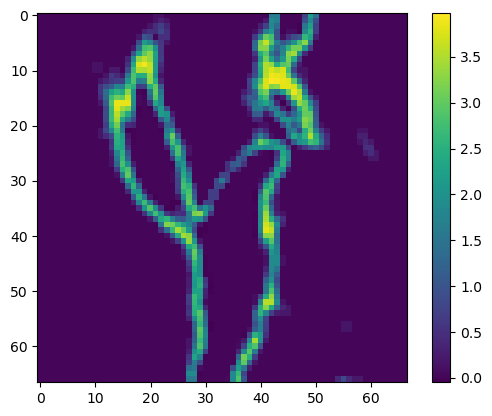

In [10]:
# theD model result
isovalue = -40

# Pass number of histogram bins too (the bin count doesn't hold meaning for uniform and Gaussian models).
start = time.monotonic()
[positiveProbabilitiesGrid, negativeProbabilitiesGrid,  maximumGrid, minimumGrid, mostProbableGrid] = computePositiveNegativeProbabilities(ensemble, isovalue,'theD',10)
#plt.figure()
#plt.imshow(positiveProbabilitiesGrid)
#plt.contour(positiveProbabilitiesGrid, levels=[0.5])
MStopologyCasesProbabilities,entropy,numCases = computeMSTopologyCasesProbabilities(positiveProbabilitiesGrid, negativeProbabilitiesGrid)
end = time.monotonic()

plt.figure()
img1 = plt.imshow(entropy)
plt.colorbar(img1)
#computeAverageEntropy(entropy)


# Visualize crossing probabilities : Probabilistic marching squares
#crossingProbabilities = probabilisticMarchingSquares(ensemble, isovalue)
#plt.figure()
#img2 = plt.imshow(crossingProbabilities)
#plt.colorbar(img2)

In [11]:
#theD model result
print("TheD model ========= entropy sum: " + "{:.2f}".format(np.sum(entropy)) + ", entropy avg: " + "{:.2f}".format(np.average(entropy)) + ", runtime: " + "{:.2f}".format(end-start) + " seconds")

# Uniform model result
start = time.monotonic()
[positiveProbabilitiesGrid, negativeProbabilitiesGrid,  maximumGrid, minimumGrid, mostProbableGrid] = computePositiveNegativeProbabilities(ensemble, isovalue,'uniform',5)
MStopologyCasesProbabilities,entropy,numCases = computeMSTopologyCasesProbabilities(positiveProbabilitiesGrid, negativeProbabilitiesGrid)
end = time.monotonic()
print("Uniform model ====== entropy sum: " + "{:.2f}".format(np.sum(entropy)) + ", entropy avg: " + "{:.2f}".format(np.average(entropy)) + ", runtime: " + "{:.2f}".format(end-start) + " seconds")


# Gaussian model result
start = time.monotonic()
[positiveProbabilitiesGrid, negativeProbabilitiesGrid,  maximumGrid, minimumGrid, mostProbableGrid] = computePositiveNegativeProbabilities(ensemble, isovalue,'Gaussian',5)
MStopologyCasesProbabilities,entropy,numCases = computeMSTopologyCasesProbabilities(positiveProbabilitiesGrid, negativeProbabilitiesGrid)
end = time.monotonic()

print("Guassian model ===== entropy sum: " + "{:.2f}".format(np.sum(entropy)) + ", entropy avg: " + "{:.2f}".format(np.average(entropy)) + ", runtime: " + "{:.2f}".format(end-start) + " seconds")

# Histogram model result
theBins = [1,2,3,4,5,6,7,8,9,10,15,25,50,100,1000]

for bin in theBins:
    start = time.monotonic()
    [positiveProbabilitiesGrid, negativeProbabilitiesGrid,  maximumGrid, minimumGrid, mostProbableGrid] = computePositiveNegativeProbabilities(ensemble, isovalue,'Histogram',bin)
    MStopologyCasesProbabilities,entropy,numCases = computeMSTopologyCasesProbabilities(positiveProbabilitiesGrid, negativeProbabilitiesGrid)
    end = time.monotonic()
    #plt.figure()
    #img1 = plt.imshow(entropy)
    #plt.colorbar(img1) '{:3d}'.format(99)
    print("Histogram model, bins: " + '{:4d}'.format(bin) + " ===== entropy sum: " + "{:.2f}".format(np.sum(entropy)) + ", entropy avg: " + "{:.2f}".format(np.average(entropy)) + ", runtime: " + "{:.2f}".format(end-start) + " seconds")

    theQuarts = [1,2,3,4,5,6,7,8,9,10,15,25,50,100,1000]

for q in theQuarts:
    start = time.monotonic()
    [positiveProbabilitiesGrid, negativeProbabilitiesGrid,  maximumGrid, minimumGrid, mostProbableGrid] = computePositiveNegativeProbabilities(ensemble, isovalue,'TheQ',q)
    MStopologyCasesProbabilities,entropy,numCases = computeMSTopologyCasesProbabilities(positiveProbabilitiesGrid, negativeProbabilitiesGrid)
    end = time.monotonic()
    #plt.figure()
    #img1 = plt.imshow(entropy)
    #plt.colorbar(img1)
    print("Quantile model, num quants: " + '{:4d}'.format(q) + " ===== entropy sum: " + "{:.2f}".format(np.sum(entropy)) + ", entropy avg: " + "{:.2f}".format(np.average(entropy)) + ", runtime: " + "{:.2f}".format(end-start) + " seconds")

TheD model ========= entropy sum: 1438.71, entropy avg: 0.32, runtime: 1.44 seconds
Uniform model ====== entropy sum: 1936.24, entropy avg: 0.43, runtime: 1.39 seconds
Guassian model ===== entropy sum: 1470.10, entropy avg: 0.33, runtime: 1.39 seconds
Histogram model, bins:    1 ===== entropy sum: 1936.24, entropy avg: 0.43, runtime: 1.45 seconds
Histogram model, bins:    2 ===== entropy sum: 1883.04, entropy avg: 0.42, runtime: 1.45 seconds
Histogram model, bins:    3 ===== entropy sum: 1646.57, entropy avg: 0.37, runtime: 1.45 seconds
Histogram model, bins:    4 ===== entropy sum: 1570.44, entropy avg: 0.35, runtime: 1.44 seconds
Histogram model, bins:    5 ===== entropy sum: 1523.68, entropy avg: 0.34, runtime: 1.47 seconds
Histogram model, bins:    6 ===== entropy sum: 1512.37, entropy avg: 0.34, runtime: 1.42 seconds
Histogram model, bins:    7 ===== entropy sum: 1508.95, entropy avg: 0.34, runtime: 1.44 seconds
Histogram model, bins:    8 ===== entropy sum: 1495.57, entropy avg: 

In [12]:
# Entropy-Guided Uncertainty Analysis of Isocontour Ensembles

# Reduced entropy : good
# Median result surprising
# best number of bins? Bin size can impact accuracy: Not good
# Quantile approach: independent of bin size, kernel density estimation: costly
# Uncertainty of uncertainty models

# Different isovalues
#  15 data points vs. 15 quantiles vs. 15 histogram bins?
# Compute [entropy(15 members) - entropy(14 members)] to know outliers or members with more information